In [1]:
%matplotlib widget
import torch
import os
import copy
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
from sphMath.reference.hydrostatic import generateHydroStatic
from sphMath.kernels import KernelType
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
# from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.integration import IntegrationSchemeType
from sphMath.enums import *

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 256
dim = 2
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3
goalRadius = 0.8

gamma = 1.4
rho_low = 1
rho_high = 2
samplingBefore = True

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2

viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.OwenScheme

L = 1
dx = L/nx
aspect = 2
band = 20
domain = buildDomainDescription(l = L, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min[0] = -L/2/aspect
domain.max[0] = L/2/aspect
domain.min[1] = 0 - band * dx
domain.max[1] = L + band * dx


simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
integrationScheme = getIntegrator(integrationScheme)

# config = {
#     'domain': domain,
#     'kernel': wrappedKernel,
#     'targetNeighbors': targetNeighbors,
#     'verletScale': 1.4,
#     'shifting': {'scheme': 'delta', 'freeSurface': False},
#     'surfaceDetection': {'active': False},
#     'pressure':{'term': 'Antuono'},
#     'fluid': {'rho0': 1, 'c_s': 20},    
#     'gravity': {'active': False, 'magnitude': 1, 'mode': 'potential'},
#     'particle': {'nx': nx + 2 * band, 'dx': L/nx, 'targetNeighbors': targetNeighbors, 'band': band},
#     'timestep':{'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
# }

solverConfig['particle'] = {
     'nx': 0.5*nx,
     'dx': L/nx,
     'targetNeighbors': targetNeighbors,
     'band': 0
}

In [3]:
area = solverConfig['particle']['dx']**2


In [4]:
band*dx

0.078125

1.4
True: dxs: [tensor(0.0039, device='cuda:0'), tensor(0.0090, device='cuda:0')], ns: [tensor(128, device='cuda:0', dtype=torch.int32), tensor(296, device='cuda:0', dtype=torch.int32)], nx: 128.0
True: dxs: [tensor(0.0039, device='cuda:0'), tensor(0.0090, device='cuda:0')], ns: [tensor(128, device='cuda:0', dtype=torch.int32), tensor(296, device='cuda:0', dtype=torch.int32)], nx: 128.0
True: dxs: [tensor(0.0039, device='cuda:0'), tensor(0.0090, device='cuda:0')], ns: [tensor(128, device='cuda:0', dtype=torch.int32), tensor(296, device='cuda:0', dtype=torch.int32)], nx: 128.0
Min rho:  1.0
Max rho:  2.0
Min pressure:  0.9305245876312256
Max pressure:  1.6775949001312256
Number of Particles:  43008
Particle dx:  0.00390625
dx 0.00390625


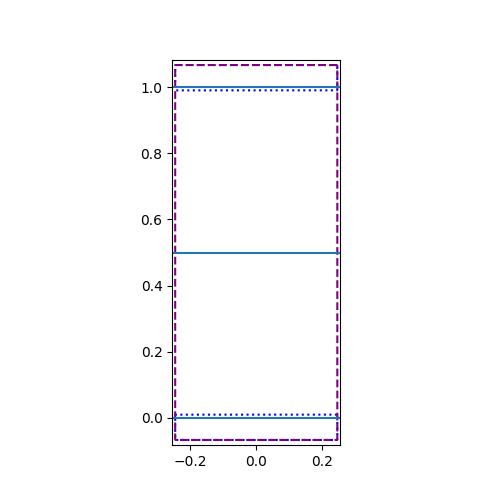

In [35]:
# inner_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([1/3,1/3]).to(points.device)))
# inner_sdf_ = lambda x: getSDF('circle')['function'](x, torch.tensor(L/4).to(x.device))
inner_sdf_ = lambda x: getSDF('box')['function'](x, torch.tensor([L/4,L/4]).to(x.device))
inner_sdf = lambda points: sampleSDF(points, inner_sdf_, invert = False)
outer_sdf_ = lambda x: getSDF('box')['function'](x, torch.tensor([L,L]).to(x.device))

outer_sdf_cutaway = operatorDict['difference'](
    outer_sdf_,
    # operatorDict['invert'](inner_sdf_),
    inner_sdf_
    # outer_sdf_
)

outer_sdf = lambda points: sampleSDF(points, outer_sdf_cutaway, invert = False)

fluid_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/2 / aspect,L/2 + band * dx]).to(x.device)), torch.tensor([0,L/2]).to(points.device)), invert = False)


bottom_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/2/aspect,band * dx / 2]).to(x.device)), torch.tensor([0,- band * dx/2]).to(points.device)), invert = False)
top_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/2/aspect,band * dx / 2]).to(x.device)), torch.tensor([0,L + band * dx/2]).to(points.device)), invert = False)


# inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([-0.5,0.5]).to(points.device)), invert = False)
# outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)
# outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.25,0.25]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)

rho_b = rho_low
rho_t = rho_high
delta = 0.0025
g = 1/2
gamma = solverConfig['fluid']['gamma']
P_0 = rho_t / gamma
print(gamma)

def rayleighTaylor_rho(positions, rho_b, rho_t, delta):
    # print('Enforcing Rayleigh-Taylor density for ', positions.shape[0], ' particles')
    y = positions[:,1]
    rho_y = rho_b + (rho_t - rho_b) * (1 + torch.exp(-(y - 0.5) / delta))**(-1)
    return rho_y
def rayleighTaylor_u(positions, rho_b, rho_t, delta, g, gamma):
    y = positions[:,1]
    rho_y = rayleighTaylor_rho(positions, rho_b, rho_t, delta)
    P_0 = rho_t / gamma
    P = P_0 - g * rho_y * (y - 1/2)
    u = P / rho_y / (gamma - 1)
    return u


regions = []
solverConfig['particle']['shortEdge'] = True
regions.append(buildRegion(sdf = top_sdf, config = solverConfig, type = 'dirichlet',
    dirichletValues={
        'velocities': lambda x, mask, state, t, dt: torch.zeros_like(x),
        'densities': lambda x, mask, state, t, dt: rayleighTaylor_rho(x, rho_low, rho_high, delta),
        'internalEnergies': lambda x, mask, state, t, dt: rayleighTaylor_u(x, rho_low, rho_high, delta, g, gamma),
    },
    updateValues={
        'velocities': lambda x, mask, state, t, dt: torch.zeros_like(x),
        'positions': lambda x, mask, state, t, dt: torch.zeros_like(x),
        'internalEnergies': lambda x, mask, state, t, dt: torch.zeros_like(x[:,0])
    })
)
regions.append(buildRegion(sdf = bottom_sdf, config = solverConfig, type = 'dirichlet',
    dirichletValues={
        'velocities': lambda x, mask, state, t, dt: torch.zeros_like(x),
        'densities': lambda x, mask, state, t, dt: rayleighTaylor_rho(x, rho_low, rho_high, delta),
        'internalEnergies': lambda x, mask, state, t, dt: rayleighTaylor_u(x, rho_low, rho_high, delta, g, gamma),
    },
    updateValues={
        'velocities': lambda x, mask, state, t, dt: torch.zeros_like(x),
        'positions': lambda x, mask, state, t, dt: torch.zeros_like(x),
        'internalEnergies': lambda x, mask, state, t, dt: torch.zeros_like(x[:,0])
    })
)


regions.append(buildRegion(sdf = fluid_sdf, config = solverConfig, type = 'fluid'))


# regions.append(buildRegion(sdf = outer_sdf, config = solverConfig, type = 'fluid', initialConditions={'densities': rho_low, 'masses': area * rho_low}))

regions[-1]['particles'].masses[regions[-1]['particles'].positions[:,1] > 0.5] = area * rho_high
regions[-1]['particles'].densities[regions[-1]['particles'].positions[:,1] > 0.5] = rho_high

import numpy as np
x = regions[-1]['particles'].positions[:,0]
y = regions[-1]['particles'].positions[:,1]

rho_y = rho_b + (rho_t - rho_b) * (1 + torch.exp(-(y - 0.5) / delta))**(-1)

regions[-1]['particles'] = regions[-1]['particles']._replace(masses = area * rho_y, densities = rho_y)

delta_y = delta * 5
v_y = delta_y * (1 + torch.cos(8 * np.pi * (x + 0.25))) * (1 + torch.cos(5 * np.pi * (y - 0.5)))

P = P_0 - g * rho_y * (y - 1/2)


mask = torch.logical_and(y >= 0.0, y <= 1.0)

print('Min rho: ', rho_y[mask].min().item())
print('Max rho: ', rho_y[mask].max().item())
print('Min pressure: ', P[mask].min().item())
print('Max pressure: ', P[mask].max().item())


solverConfig['gravity']['active'] = True
solverConfig['gravity']['magnitude'] = g
solverConfig['gravity']['mode'] = 'directional'
solverConfig['gravity']['direction'] = torch.tensor([0, -1], device = device, dtype = dtype)




# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)

axis[0,0].set_xlim(domain.min[0].cpu().numpy() - dx, domain.max[0].cpu().numpy() + dx)
axis[0,0].set_ylim(domain.min[1].cpu().numpy() - dx, domain.max[1].cpu().numpy() + dx)
axis[0,0].set_aspect('equal', adjustable='box')
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = False)
axis[0,0].set_aspect('equal', adjustable='box')
print('Number of Particles: ', sum([region['particles'].positions.shape[0] for region in regions ]))

print('Particle dx: ', regions[0]['particles'].masses.mean().item()**(1/2))
print('dx', dx)
axis[0,0].axhline(0.5)
axis[0,0].axhline(0)
axis[0,0].axhline(1)

In [36]:
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles

In [37]:
particleState, config, rigidBodies = initializeSimulation(scheme, solverConfig, regions)
particleState.alpha0s = torch.ones_like(particleState.densities)
particleState.divergence = torch.zeros_like(particleState.densities)
particles = copy.deepcopy(particleState)


In [38]:
from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, SupportScheme
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr

bandMask = torch.logical_and(y > 0.3, y < 0.7)

particleState.velocities[bandMask, 1] = v_y[bandMask]

# simulationState = tate
neighborhood, neighbors = evaluateNeighborhood(particleState, domain, kernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
numNeighbors = coo_to_csr(filterNeighborhoodByKind(particleState, neighbors.neighbors, which = 'noghost')).rowEntries
densities = computeDensity(particleState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)


print(densities[~bandMask].min(), densities[~bandMask].max())

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = P, rho = rho_y, gamma = gamma)
particleState.pressures = P_
particleState.internalEnergies = u_


mask = torch.logical_and(y >= 0.0, y <= 1.0)
print('Min rho: ', densities[mask].min().item())
print('Max rho: ', densities[mask].max().item())
print('Min pressure: ', P_[mask].min().item())
print('Max pressure: ', P_[mask].max().item())

tensor(1.0000, device='cuda:0') tensor(2.0000, device='cuda:0')
Min rho:  1.0000026226043701
Max rho:  2.0000064373016357
Min pressure:  0.9305245876312256
Max pressure:  1.6775949001312256


In [39]:
print(rho_t *(1/gamma - 1/4))
print(rho_t * (1/gamma + 1/8))

0.9285714285714286
1.6785714285714286


In [40]:

particleSystem = SimulationSystem(domain, None, 0., copy.deepcopy(particleState), priorStep = None)
for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)

from sphMath.modules.timestep import computeTimestep
dt = computeTimestep(scheme, 0, particleSystem.systemState, solverConfig, None)

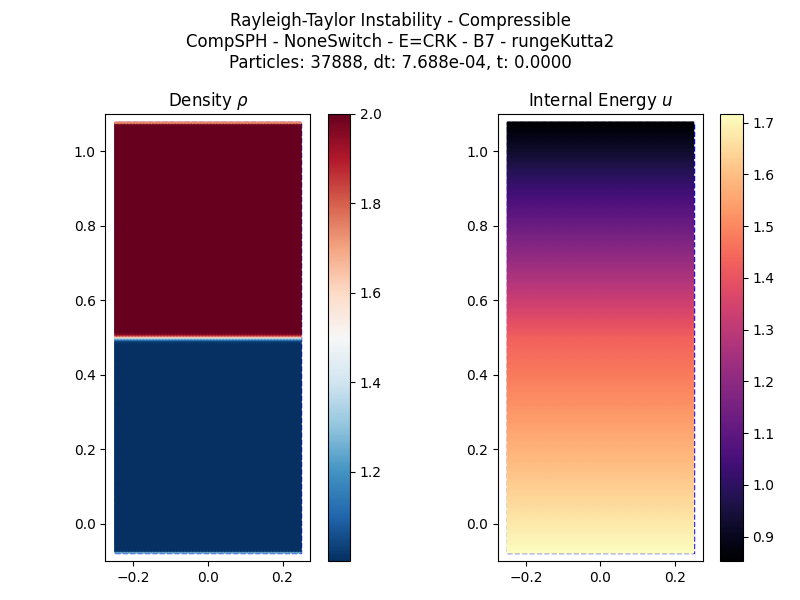

In [41]:
fluidParticles = particleSystem.systemState
fig, axis = plt.subplots(1, 2, figsize = (8, 6), squeeze = False)

markerSize = 1
densityPlotState = visualizeParticles(fig, axis[0,0],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = densities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = True,
                     cmap = 'RdBu_r',
                     title='Density $\\rho$',
                     markerSize = markerSize,)

velocityPlotState = visualizeParticles(fig, axis[0,1],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.pressures, 
                     which = 'fluid',
                     mapping = 'L2',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = True,
                     cmap = 'magma',
                     title='Internal Energy $u$',
                     markerSize = markerSize,)

fig.suptitle(f"Rayleigh-Taylor Instability - Compressible\n{solverConfig['schemeName']}\nParticles: {fluidParticles.positions.shape[0]}, dt: {dt:1.3e}, t: {particleSystem.t:.4f}", fontsize=12)

axis[0,0].set_ylim(-0.1,1.1)
axis[0,1].set_ylim(-0.1,1.1)


fig.tight_layout()

In [42]:
print((1/gamma - 1/4) * rho_t)
mask = torch.logical_and(y >= 0.0, y <= 1.0)
P[bandMask].min()

0.9285714285714286


tensor(1.2313, device='cuda:0')

In [43]:
imagePrefix = './images/rayleighTaylor/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

# config['diffusion'] = {'alpha': 0.1}
# dt = computeDT(particleSystem.systemState, CFL = CFL, solverConfig = solverConfig)
# print()
dt = computeTimestep(scheme, 0, particleSystem.systemState, solverConfig, None)
# dt = 1e-3
print(dt)

particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, simulator, config, priorStep = particleSystem.priorStep, verbose = False)

tensor(0.0008, device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')


In [44]:
particles = copy.deepcopy(particleState)
particleSystem = SimulationSystem(domain, None, 0., copy.deepcopy(particleState), priorStep = None)
for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)


t = 0
timeLimit = 10
timesteps = int(timeLimit / dt)
plotInterval = 20

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, simulator, config, priorStep = particleSystem.priorStep, verbose = False)
    particleSystem.priorStep = [updates[-1], currentState[-1]]
    
    
    # particleSystem.systemState.velocities = particleSystem.systemState.velocities * 0.99

    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        # rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        # rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        # rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        # kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        # totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        # totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        # fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')
        fig.suptitle(f"Rayleigh-Taylor Instability - Compressible\n{solverConfig['schemeName']}\nParticles: {fluidParticles.positions.shape[0]}, dt: {dt:1.3e}, t: {particleSystem.t:.4f}", fontsize=12)

        updatePlot(densityPlotState, particleSystem.systemState, particleSystem.systemState.densities)
        updatePlot(velocityPlotState, particleSystem.systemState, particleSystem.systemState.internalEnergies)
        # updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.pressures)

        axis[0,0].set_ylim(0,1)
        axis[0,1].set_ylim(0,1)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
    # if i > 90:
        # break
    

  0%|          | 0/13006 [00:00<?, ?it/s]

tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000,  ..., 0.

KeyboardInterrupt: 

In [45]:

import subprocess
import shlex
import imageio.v2 as imageio
from skimage.transform import resize, rescale
from skimage.io import imread

def postProcess(imagePrefix, fps, timesteps, exportName):
    fileList = os.listdir(imagePrefix)
    fileList = [f for f in fileList if f.endswith('.png') and f.startswith('frame_')]
    fileList = sorted(fileList)

    writer = imageio.get_writer(f'{imagePrefix}/output.mp4', fps=50, bitrate='10M')
    for image in fileList:
        writer.append_data(imageio.imread(imagePrefix + image))
    writer.close()

    images = []
    for image in fileList:
        images.append(imread(imagePrefix + image))

    currentImageSize = images[0].shape
    currentLongEdge = max(images[0].shape[0], images[0].shape[1])
    targetLongEdge = 800
    ratio = targetLongEdge / currentLongEdge

    images = [(rescale(image, ratio, anti_aliasing=True, channel_axis=-1)*255).astype('uint8') for image in images]

    # for image in images:
        # print(image.shape)
        # break

    # images = [resizeImageLongEdge(i, 600) for i in images]

    imageio.mimsave(f'{imagePrefix}/output.gif', images, fps=50, loop=0)
    
    print('Copying video to videos folder')
    os.makedirs(f'./videos/', exist_ok= True)
    # subprocess.run(shlex.split(f'cp {imagePrefix}/output.mp4 ./videos/{exportName}.mp4'))
    subprocess.run(shlex.split(f'cp {imagePrefix}/output.gif ./videos/{exportName}.gif'))
    lastFrameFile = f'{imagePrefix}/frame_{timesteps - 1:05d}.png'
    subprocess.run(shlex.split(f'cp {lastFrameFile} ./videos/{exportName}.png'))
    print('Done!')

In [46]:
postProcess(imagePrefix, fps = 50, timesteps = timesteps, exportName = 'rayleighTaylor')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 600) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Copying video to videos folder
Done!


cp: cannot stat './images/rayleighTaylor//frame_13005.png': No such file or directory
